# Bright Machines Pick and Place Demo

In [18]:
%load_ext autoreload
%autoreload 2
import sys
import pathlib
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

from torchsummary import summary

from pick_place.models.resnet import ResNet18
from pick_place.models.scnn import SiameseCNN
from pick_place.utils.configs import Configs
from pick_place.datasets.image_position_dataset import ImagePositionDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# gpu on which the model will evaluate test points
device = 3

### ResNet18 Evaluation

In [3]:
dataset_path = "/data/brightmachines/dataset/"

In [4]:
### Model Initialization ###

# path to folder storing checkpoints of the model weights to use for evaluation
ckpt_path = pathlib.Path("../ckpts/resnet_transf_l1/")
# update below to use different model checkpoints
ckpt = ckpt_path  / "resnet_transf_l1_best.pth"
config = ckpt_path / "resnet_transf_l1.yml"

resnet_config = Configs.load_config(config)

model = Configs.load_model(resnet_config, ckpt).to(device)

In [11]:
### Data Loading ###

data = ImagePositionDataset(
    dataset_path=f"/data/brightmachines/dataset/",
    label_name="xyr", 
    use_transform=False)

train_data, val_data, test_data = Configs.load_dataset(resnet_config)

In [13]:
### Model Evaluation ###

# random test points selected, can be modified to test specific images
test_points = np.random.choice(len(test_data), size=5, replace = False)


for pt in test_points:
    assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

for pt in test_points:
    image, label = test_data[pt]
    image = image.to(device).unsqueeze(0)
    label = data[0][1] - label
    label = label.numpy()

    pred = model(image).squeeze(0)
    pred = pred.detach().cpu().numpy()

    plt.imshow(image.detach().cpu().squeeze(0).squeeze(0), cmap="gray")
    plt.show()
    print(f"Test Image Index: {pt}")
    print(f"Prediction: {pred}")
    print(f"Ground Truth: {label}")
    print(f"Delta: {label - pred}")

RuntimeError: CUDA error: invalid device function

In [7]:
### Evaluation Speed Testing ###
num_points = 100
test_points = np.random.choice(len(test_data), size=num_points, replace = False)

for pt in test_points:
    assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

deltas = np.zeros((num_points, 3))
i = 0
start_time = time.time()
for pt in test_points:
    image, label = test_data[pt]
    image = image.to(device).unsqueeze(0)
    label = data[0][1] - label
    label = label.numpy()

    pred = model(image).squeeze(0)
    pred = pred.detach().cpu().numpy()
    delta = label - pred
    deltas[i] = delta
    i += 1
end_time = time.time()

print()
print(f"Time taken to evaluate {len(test_points)} test points: {round(end_time - start_time, 2)}s")
print(f"Time taken per test point: {round((end_time - start_time) / len(test_points), 3)}s")

print()
print(f"average L1 errors: {np.mean(np.abs(deltas), axis = 0)}")
print(f"total average L1 error: {np.mean(np.abs(deltas))}")

RuntimeError: CUDA error: invalid device function

In [8]:
print(summary(model, data[0][0].shape, device=torch.device(0)))

AttributeError: 'torch.device' object has no attribute 'lower'

### SiameseCNN Evaluation

In [31]:
### Model Initialization ###
device = 3
# path to folder storing checkpoints of the model weights to use for evaluation
ckpt_path = pathlib.Path("../ckpts/scnn_l1_3/")
# update below to use different model checkpoints
ckpt = ckpt_path / "scnn_l1_best.pth"
config = ckpt_path / "scnn_l1_3.yml"

# data_xyr_1 ckpt
xyr1_ckpt_path = pathlib.Path("../ckpts/scnn_l1/")
xyr1_ckpt = xyr1_ckpt_path / "scnn_l1_best.pth"
xyr1_config = xyr1_ckpt_path / "scnn_l1.yml"

# data_xyr_2 ckpt
xyr2_ckpt_path = pathlib.Path("../ckpts/scnn_l1_2/")
xyr2_ckpt = xyr2_ckpt_path / "scnn_l1_best.pth"
xyr2_config = xyr2_ckpt_path / "scnn_l1_2.yml"

# data_xyr_3_crop ckpt
xyr3_c_ckpt_path = pathlib.Path("../ckpts/scnn_l1_3_crop/")
xyr3_c_ckpt = xyr3_c_ckpt_path / "scnn_resnet_l1_0.59.pth"
xyr3_c_config = xyr3_c_ckpt_path / "scnn_l1_3.yml"

scnn_config  = Configs.load_config(config)
xyr1_config = Configs.load_config(xyr1_config)
xyr2_config = Configs.load_config(xyr2_config)
xyr3_c_config = Configs.load_config(xyr3_c_config)
model = Configs.load_model(xyr3_c_config, xyr3_c_ckpt).to(device)

In [32]:
xyr1_config['dataset_params']['crop'] = 500
xyr2_config['dataset_params']['crop'] = 500
scnn_config['dataset_params']['crop'] = 500

In [33]:
### Data Loading ###
train_data, val_data, test_data = Configs.load_dataset(xyr3_c_config)
_, _, xyr1_data = Configs.load_dataset(xyr1_config)
_, _, xyr2_data = Configs.load_dataset(xyr2_config)
_, _, xyr3_data = Configs.load_dataset(scnn_config)

#test_data = xyr3_data
#train_data, val_data, test_data = Configs.load_dataset(xyr1_config)

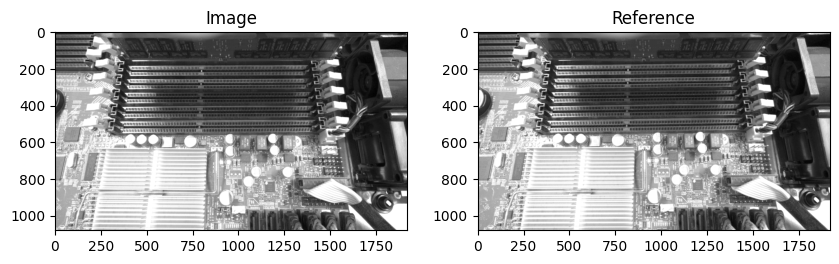

Test Image Index: 47
Prediction: [-0.06454697 -1.9299198   0.06084169]
Ground Truth: [ 1.  -2.5 -0.5]
Delta: [ 1.064547   -0.57008016 -0.5608417 ]



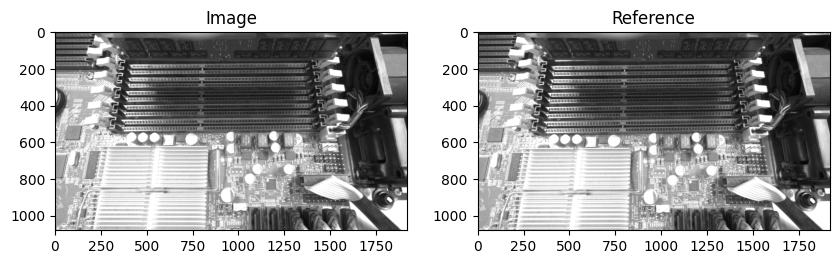

Test Image Index: 86
Prediction: [-0.01797428  0.66376936 -0.01049199]
Ground Truth: [-1.    0.5  -0.25]
Delta: [-0.98202574 -0.16376936 -0.239508  ]



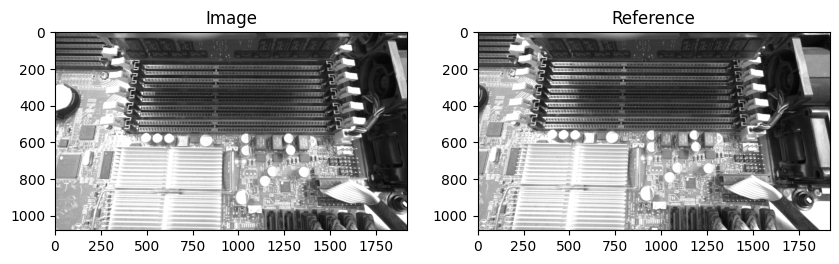

Test Image Index: 88
Prediction: [ 0.164585   10.248425   -0.27950996]
Ground Truth: [ 2. 11.  0.]
Delta: [1.835415   0.75157547 0.27950996]



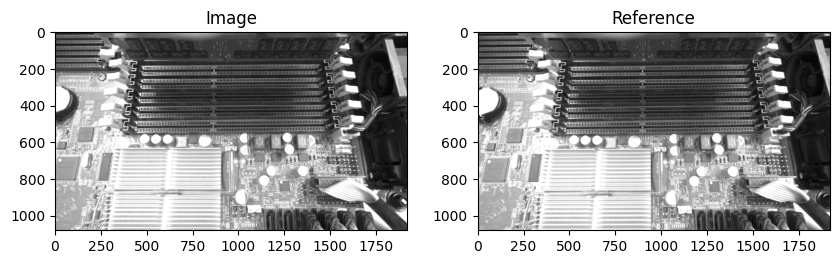

Test Image Index: 48
Prediction: [-0.1020213  -4.657973    0.13007742]
Ground Truth: [-0.5  -4.   -0.25]
Delta: [-0.3979787   0.6579728  -0.38007742]



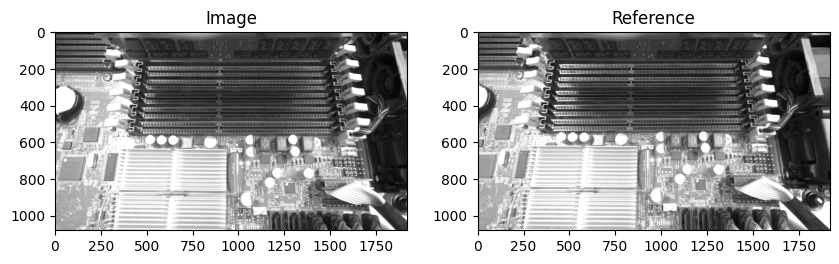

Test Image Index: 107
Prediction: [ 0.12070964  7.5999165  -0.20852798]
Ground Truth: [ 2.    8.   -0.25]
Delta: [ 1.8792903   0.40008354 -0.04147202]



In [34]:
### Model Evaluation ###

# random test points selected, can be modified to test specific images
test_points = np.random.choice(len(test_data), size=5, replace = False)

for pt in test_points:
    assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

for pt in test_points:
    image, reference, label = test_data[pt]
    image = image.to(device).unsqueeze(0)
    reference = reference.to(device).unsqueeze(0)
    label = label.numpy()

    pred = model(image, reference).squeeze(0)
    pred = pred.detach().cpu().numpy()

    fig, axarr = plt.subplots(1, 2, figsize = (10, 10))
    axarr[0].imshow(image.detach().cpu().squeeze(0)[0].int(), cmap="gray",)
    axarr[0].set_title("Image")
    axarr[1].imshow(reference.detach().cpu().squeeze(0)[0].int(), cmap="gray")
    axarr[1].set_title("Reference")
    plt.show()
    print(f"Test Image Index: {pt}")
    print(f"Prediction: {pred}")
    print(f"Ground Truth: {label}")
    print(f"Delta: {label - pred}")
    print()

In [35]:
### Evaluation Speed Testing ###
def eval_speed():
    num_points = 100
    test_points = np.random.choice(len(test_data), size=num_points, replace = False)

    for pt in test_points:
        assert pt < len(test_data), f"test point = {pt} is outside of the range of data points available. Size of test set = {len(test_data)}"

    deltas = np.zeros((num_points, 3))
    i = 0
    start_time = time.time()
    for pt in test_points:
        image, reference, label = test_data[pt]
        image = image.to(device).unsqueeze(0)
        reference = reference.to(device).unsqueeze(0)
        label = label.numpy()

        pred = model(image, reference).squeeze(0)
        pred = pred.detach().cpu().numpy()
        delta = label - pred
        deltas[i] = delta
        i += 1
    end_time = time.time()

    print()
    print(f"Time taken to evaluate {len(test_points)} test points: {round(end_time - start_time, 2)}s")
    print(f"Time taken per test point: {round((end_time - start_time) / len(test_points), 3)}s")

    print()
    print(f"average L1 errors: {np.mean(np.abs(deltas), axis = 0)}")
    print(f"total average L1 error: {np.mean(np.abs(deltas))}")

test_data = xyr1_data
eval_speed()
test_data = xyr2_data
eval_speed()
test_data = xyr3_data
eval_speed()


Time taken to evaluate 100 test points: 22.86s
Time taken per test point: 0.229s

average L1 errors: [ 7.12778503 13.66847901  0.38498741]
total average L1 error: 7.060417150650173

Time taken to evaluate 100 test points: 22.06s
Time taken per test point: 0.221s

average L1 errors: [2.03657522 9.64847356 0.43507716]
total average L1 error: 4.040041978396475

Time taken to evaluate 100 test points: 22.06s
Time taken per test point: 0.221s

average L1 errors: [1.00427608 0.37643036 0.47656201]
total average L1 error: 0.6190894818740587


### Iterative Process

In [36]:
data = ImagePositionDataset(
	dataset_path=f"/data/brightmachines/data_xyr/", 
	label_name="xyr_3", 
    img_height=1080,
    img_width=1920,
	use_transform=False,
    crop=500)

In [37]:
def find_nearest_image(position):
    def closest_item(lst, K):
        return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    x_decimals = [0.177, 0.677]
    K = position[0] % 1
    position[0] = position[0] // 1 + closest_item(x_decimals, K)
    
    y_decimals = [0.42, 0.92]
    K = position[1] % 1
    position[1] = position[1] // 1 + closest_item(y_decimals, K)

    r_decimals = [0, 0.25, 0.5, 0.75]
    K = position[2] % 1
    position[2] = position[2] // 1 + closest_item(r_decimals, K)

    return position

In [38]:
### Iterative Loop ###

# "take a picture"
image, reference = np.random.choice(len(data), size=2, replace = False)
image, position = data[image]
position = np.array(position)
reference, goal = data[reference]
goal = np.array(goal)
print(f"initial position: {position}")
print(f"reference position: {goal}")
print()

# model expects images with 3 channels
image = image.repeat(3, 1, 1).to(device).unsqueeze(0)
reference = reference.repeat(3, 1, 1).to(device).unsqueeze(0)

# five iterations
#TODO modify so that it terminates when movements are smaller than some threshold
for i in range(5):
    # model output how to move the arm to position
    print(f"iteration: {i + 1}")
    delta_pos = model(image, reference)[0].detach().cpu()
    delta_pos = np.array(delta_pos)
    print(f"{delta_pos} : amount to move arm")

    # shrink movements that are bigger than a certain threshold to avoid overshooting
    for i in range(len(delta_pos)):
        if delta_pos[i] >= 1:
            delta_pos[i] = delta_pos[i] * 0.8 

    # TODO Add code here which moves the robot arm
    for i in range(len(delta_pos)):
        position[i] += delta_pos[i]
    print(f"{position} : updated position")
    print(f"{goal} : reference position")
    print(f"{[abs(position[i] - goal[i]) for i in range(3)]} : distance from reference:")
    
    # need to find a picture in the dataset, so need to find nearest image in dataset
    # ignore for robot movements
    position = find_nearest_image(position)
    print(f"{position} : nearest image to the updated position")

    # TODO "take a picture" at the new position
    #print(f"image path: {position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    if image == None:
        image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}000000000002_-850_1.0_0_{position[2]}")
        if image == None:
            raise Exception("No nearest image found")
    image = image.repeat(3, 1, 1).to(device).unsqueeze(0).float()
    print()

initial position: [ 516.291  -86.693 -179.835]
reference position: [ 516.291  -81.693 -179.335]

iteration: 1
[ 0.07493684  4.9461956  -0.13648629] : amount to move arm
[ 516.36597   -82.736046 -179.9715  ] : updated position
[ 516.291  -81.693 -179.335] : reference position
[0.07495117, 1.043045, 0.63648987] : distance from reference:
[ 516.177  -82.58  -180.   ] : nearest image to the updated position
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.177_-82.58_-850_1.0_0_-180.0.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.177_-82.58000000000002_-850_1.0_0_-180.0.png'


Exception: No nearest image found

In [15]:
### Iterative Loop Graphing ###

# "take a picture"
image, reference = np.random.choice(len(data), size=2, replace = False)
image, position = data[image]
position = np.array(position)
reference, goal = data[reference]
goal = np.array(goal)
iterations = 10
x_errors = [abs(position[0] - goal[0])]
y_errors = [abs(position[1] - goal[1])]
r_errors = [abs(position[2] - goal[2])]
l1_errors = [x_errors[0] + y_errors[0] + r_errors[0]]

# model expects images with 3 channels
image = image.repeat(3, 1, 1).to(device).unsqueeze(0)
reference = reference.repeat(3, 1, 1).to(device).unsqueeze(0)

for i in range(iterations):
    # model output how to move the arm to position
    print(image.shape, reference.shape)
    delta_pos = model(image, reference)[0].detach().cpu()
    delta_pos = np.array(delta_pos)

    # shrink movements that are bigger than a certain threshold to avoid overshooting
    # for i in range(len(delta_pos)):
    #     if abs(delta_pos[i]) >= 0.5:
    #         delta_pos[i] = delta_pos[i] * 0.8 

    # TODO Add code here which moves the robot arm
    for i in range(len(delta_pos)):
        position[i] += delta_pos[i]

    x_error = abs(position[0] - goal[0])
    y_error = abs(position[1] - goal[1])
    r_error = abs(position[2] - goal[2])
    l1_error = x_error + y_error + r_error

    x_errors.append(x_error)
    y_errors.append(y_error)
    r_errors.append(r_error)
    l1_errors.append(l1_error)
    
    # need to find a picture in the dataset, so need to find nearest image in dataset
    # ignore for robot movements
    position = find_nearest_image(position)

    # "take a picture" at the new position
    #print(f"image path: {position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
    if image == None:
        image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}000000000002_-850_1.0_0_{position[2]}")
        if image == None:
            print("No nearest image found")
            continue
    image = image.repeat(3, 1, 1).to(device).unsqueeze(0).float()

plt.plot(range(iterations + 1), x_errors, label = "x error")
plt.plot(range(iterations + 1), y_errors, label = "y error")
plt.plot(range(iterations + 1), r_errors, label = "r error")
plt.plot(range(iterations + 1), l1_errors, label = "total L1 error")
plt.title("Errors vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("L1 Error")
plt.legend()
plt.show()

torch.Size([1, 3, 1080, 1920]) torch.Size([1, 3, 1080, 1920])
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-77.58_-850_1.0_0_-180.5.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-77.58000000000002_-850_1.0_0_-180.5.png'
No nearest image found


AttributeError: 'NoneType' object has no attribute 'shape'

[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.177_-81.58_-850_1.0_0_-179.75.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.177_-81.58000000000002_-850_1.0_0_-179.75.png'
515.177_-81.58_-850_1.0_0_-179.75
No nearest image found #1
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.677_-78.58_-850_1.0_0_-180.25.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/515.677_-78.58000000000002_-850_1.0_0_-180.25.png'
515.677_-78.58_-850_1.0_0_-180.25
No nearest image found #2
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-73.08_-850_1.0_0_-180.75.png'
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr_3/516.677_-73.08000000000002_-850_1.0_0_-180.75.png'
516.677_-73.08_-850_1.0_0_-180.75
No nearest image found #3
[Errno 2] No such file or directory: '/data/brightmachines/data_xyr/data_xyr

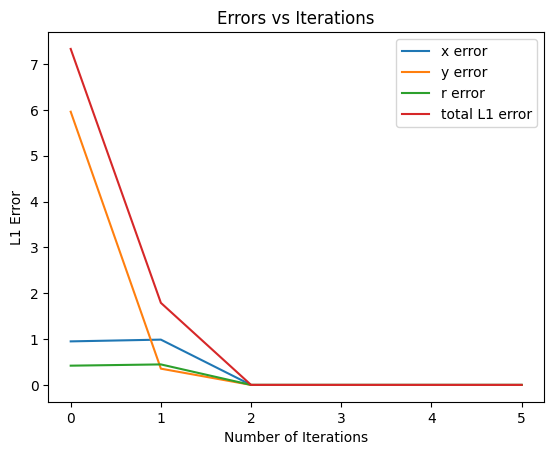

In [39]:
number_tests = 100
iterations = 5
x_errors = np.zeros(iterations + 1)
y_errors = np.zeros(iterations + 1)
r_errors = np.zeros(iterations + 1)
l1_errors = np.zeros(iterations + 1)
num_not_found = 1

for _ in range(number_tests):
    # "take a picture"
    image, reference = np.random.choice(len(data), size=2, replace = False)
    image, position = data[image]
    position = np.array(position)
    reference, goal = data[reference]
    goal = np.array(goal)
    x_error = abs(position[0] - goal[0])
    y_error = abs(position[1] - goal[1])
    r_error = abs(position[2] - goal[2])
    l1_error = x_error + y_error + r_error

    x_errors[0] += x_error
    y_errors[0] += y_error
    r_errors[0] += r_error
    l1_errors[0] += l1_error

    # model expects images with 3 channels
    image = image.repeat(3, 1, 1).to(device).unsqueeze(0)
    reference = reference.repeat(3, 1, 1).to(device).unsqueeze(0)

    for iter in range(iterations):
        # model output how to move the arm to position
        if image == None:
            continue
        delta_pos = model(image, reference)[0].detach().cpu()
        delta_pos = np.array(delta_pos)

        # shrink movements that are bigger than a certain threshold to avoid overshooting
        # for i in range(len(delta_pos)):
        #     if abs(delta_pos[i]) >= 0.5:
        #         delta_pos[i] = delta_pos[i] * 0.8 

        # TODO Add code here which moves the robot arm
        for i in range(len(delta_pos)):
            position[i] += delta_pos[i]

        x_error = abs(position[0] - goal[0])
        y_error = abs(position[1] - goal[1])
        r_error = abs(position[2] - goal[2])
        l1_error = x_error + y_error + r_error

        x_errors[iter+1] += x_error
        y_errors[iter+1] += y_error
        r_errors[iter+1] += r_error
        l1_errors[iter+1] += l1_error
        
        # need to find a picture in the dataset, so need to find nearest image in dataset
        # ignore for robot movements
        position = find_nearest_image(position)

        # "take a picture" at the new position
        #print(f"image path: {position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
        image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
        if image == None:
            image = data.get_image(f"{position[0]:.3f}_{position[1]:.2f}000000000002_-850_1.0_0_{position[2]}")
            if image == None:
                print(f"{position[0]:.3f}_{position[1]:.2f}_-850_1.0_0_{position[2]}")
                print(f"No nearest image found #{num_not_found}")
                num_not_found += 1
                continue
        image = image.repeat(3, 1, 1).to(device).unsqueeze(0).float()

for i in range(iterations + 1):
    x_errors[i] = x_errors[i] / number_tests
    y_errors[i] = y_errors[i] / number_tests
    r_errors[i] = r_errors[i] / number_tests
    l1_errors[i] = l1_errors[i] / number_tests

plt.plot(range(iterations + 1), x_errors, label = "x error")
plt.plot(range(iterations + 1), y_errors, label = "y error")
plt.plot(range(iterations + 1), r_errors, label = "r error")
plt.plot(range(iterations + 1), l1_errors, label = "total L1 error")
plt.title("Errors vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("L1 Error")
plt.legend()
plt.show()

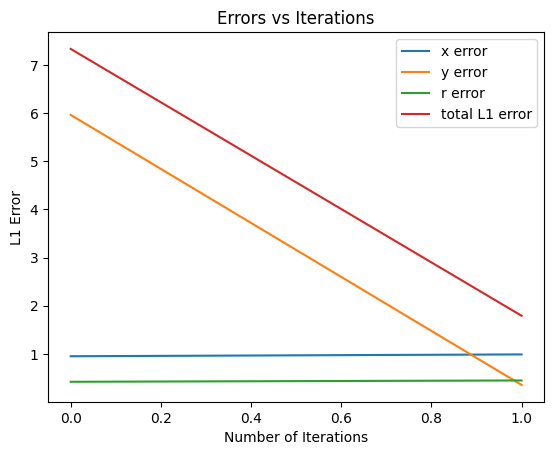

In [41]:
plt.plot(range(2), x_errors[:2], label = "x error")
plt.plot(range(2), y_errors[:2], label = "y error")
plt.plot(range(2), r_errors[:2], label = "r error")
plt.plot(range(2), l1_errors[:2], label = "total L1 error")
plt.title("Errors vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("L1 Error")
plt.legend()
plt.show()

In [21]:
for i in range(1, iterations + 1):
    print(f"{i} iterations:")
    print(f"l1 errors = [{x_errors[i]:.3f} {y_errors[i]:.3f} {r_errors[i]:.3f}]")
    print(f"average l1_error = {l1_errors[i] / 3:.3f}")
    print()

1 iterations:
l1 errors = [0.246 0.530 0.359]
average l1_error = 0.378

2 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

3 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

4 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

5 iterations:
l1 errors = [0.000 0.000 0.000]
average l1_error = 0.000

